# Makkah Weather Analysis
# Part 2: Modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# pd.set_option('display.max_rows', None)

# ================================================

from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from time import time
import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor ,RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet



from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
from sktime.transformers.single_series.detrend import ConditionalDeseasonalizer
from sktime.regression.compose import TimeSeriesForestRegressor

# Content:
## 1- Load Data
## 2- Features Selection
- Group Data Daily, /monthliy and Yearly and Extraxt Min, Max and Ave. 
- Removing Sesonality

## 3- Models Selection
- Check Different Models To Forcast Minimum Temperatures
    - Hyper-parameters Tuning
- Check Different Models To Forcast Maximum Temperatures
    - Hyper-parameters Tuning

## 1- Load Data

In [2]:
# Sesonality test
""" If p-value < 0.05 , then data is not sesonal"""
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [3]:
makkah_weather = pd.read_csv('../data/cleand.csv', parse_dates=['date'])
makkah_weather.head()

,city,date,temperature,condition,wind,humidity,barometer,visibility
0,makkah,2009-09-11 00:00:00,30.0,Clear,7.0,0.62,1005.0,16.0
1,makkah,2009-09-11 01:00:00,28.0,Clear,0.0,0.66,1004.0,16.0
2,makkah,2009-09-11 02:00:00,27.0,Clear,7.0,0.66,1004.0,16.0
3,makkah,2009-09-11 03:00:00,27.0,Clear,7.0,0.66,1004.0,16.0
4,makkah,2009-09-11 04:00:00,27.0,Clear,0.0,0.66,1004.0,16.0


In [4]:
# Limit the data to start from 2016
s = pd.Timestamp(year=2016, month=1, day=1)
makkah_weather = makkah_weather[makkah_weather.date >= s].reset_index(drop=True)
makkah_weather.head()

,city,date,temperature,condition,wind,humidity,barometer,visibility
0,makkah,2016-01-01 00:00:00,21.0,Passing clouds,7.0,0.64,1015.0,16.0
1,makkah,2016-01-01 01:00:00,20.0,Passing clouds,7.0,0.60,1014.0,16.0
2,makkah,2016-01-01 02:00:00,20.0,Passing clouds,11.0,0.60,1014.0,16.0
3,makkah,2016-01-01 03:00:00,20.0,Passing clouds,11.0,0.56,1014.0,16.0
4,makkah,2016-01-01 04:00:00,20.0,Passing clouds,11.0,0.56,1014.0,16.0


## 2- Features Selection

#### 1- Group Data Daily, /monthliy and Yearly and Extraxt Min, Max and Ave. 

In [5]:
# Daily max , min & mean data
d_temp = makkah_weather.groupby([makkah_weather['date'].dt.date]).agg(['min','max','mean'])

# Monthly max , min & mean data
m_temp = makkah_weather.groupby([makkah_weather['date'].dt.year, makkah_weather['date'].dt.month
                                ]).agg(['min','max','mean'])

# yearly max , min & mean data
y_temp = makkah_weather.groupby(makkah_weather['date'].dt.year).agg(['min','max','mean'])


In [6]:
# Daily max and min temperature
dmax = d_temp['temperature']['max'].reset_index(drop=True)
dmin = d_temp['temperature']['min'].reset_index(drop=True)

# yearly max and min temperature
mmax = m_temp['temperature']['max'].reset_index(drop=True)
mmin = m_temp['temperature']['min'].reset_index(drop=True)

# yearly max and min temperature
ymax = y_temp['temperature']['max'].reset_index(drop=True)
ymin = y_temp['temperature']['min'].reset_index(drop=True)

#### 2- Removing Sesonality

Sesonality test for Min temp.
ADF Statistic: -7.718420
p-value: 0.000000


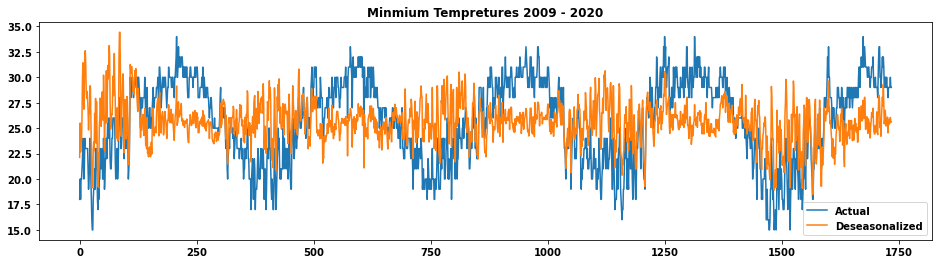

In [7]:
# Minimum Temperatures
t = Deseasonalizer(model='multiplicative', sp=365)
y_dmin = t.fit_transform(dmin)
plot_ys(dmin, y_dmin,labels=['Actual','Deseasonalized']);
plt.title('Minmium Tempretures 2009 - 2020');
print('Sesonality test for Min temp.')
perform_adf_test(y_dmin)

Sesonality test for Max temp.
ADF Statistic: -13.990028
p-value: 0.000000


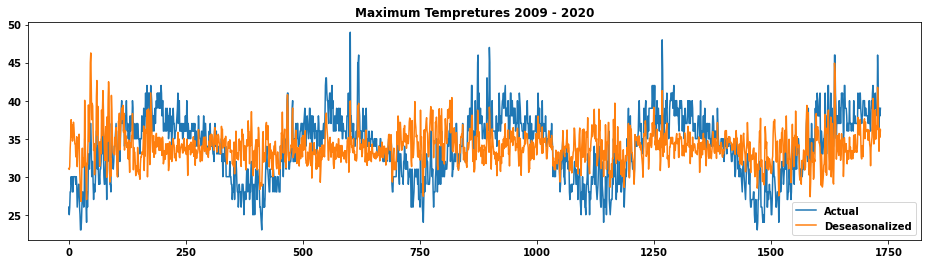

In [8]:
# Maximum Temperatures
y_dmax = t.fit_transform(dmax)
plot_ys(dmax, y_dmax,labels=['Actual','Deseasonalized']);
plt.title('Maximum Tempretures 2009 - 2020');
print('Sesonality test for Max temp.')
perform_adf_test(y_dmax)

## 3- Models Selection

#### 1- Check Different Models To Forcast Minmum Temperatures

In [9]:
y_train, y_test = temporal_train_test_split(y_dmin, test_size=30)
print(y_train.shape, y_test.shape)

(1704,) (30,)


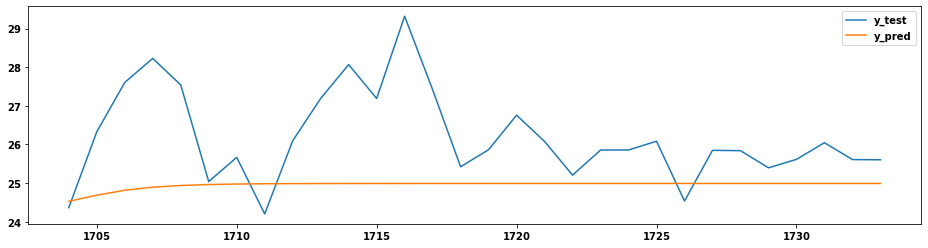

In [10]:
fh = np.arange(len(y_test)) + 1
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(t.fit_transform(y_train))
y_pred = forecaster.predict(fh)
plot_ys(y_test, y_pred, labels=[ "y_test", "y_pred"]);

In [11]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.0514
RMSE 1.69828


,test,pred
1704,24.0,25.0
1705,26.0,25.0
1706,28.0,25.0
1707,28.0,25.0
1708,28.0,25.0
1709,25.0,25.0
1710,26.0,25.0
1711,24.0,25.0
1712,26.0,25.0
1713,27.0,25.0


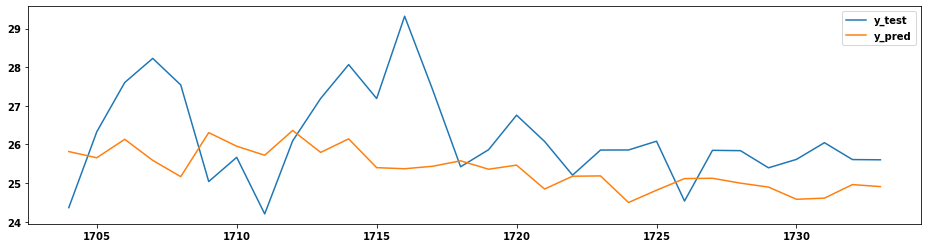

In [12]:
regressor = KNeighborsRegressor(n_neighbors=5)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
forecaster.fit(t.fit_transform(y_train))
y_pred = forecaster.predict(fh)
plot_ys(y_test, y_pred, labels=[ "y_test", "y_pred"]);

In [13]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.04597
RMSE 1.44828


,test,pred
1704,24.0,26.0
1705,26.0,26.0
1706,28.0,26.0
1707,28.0,26.0
1708,28.0,25.0
1709,25.0,26.0
1710,26.0,26.0
1711,24.0,26.0
1712,26.0,26.0
1713,27.0,26.0


{'seasonal': 'add', 'sp': 90}


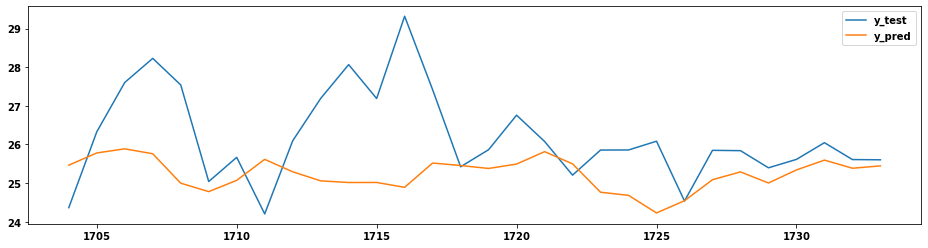

In [14]:
forecaster = ExponentialSmoothing(seasonal='multiplicative', sp=10) 
param_grid = {'seasonal':['add', 'multiplicative' ],'sp':[30,60,90,120,150,180,
                                                                210,240,270,300,330,360]}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"]);

print(gscv.best_params_)

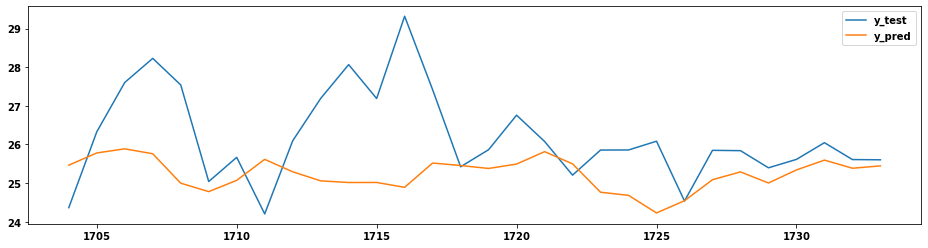

In [15]:
forecaster = gscv.best_forecaster_
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys( y_test, y_pred, labels=["y_test", "y_pred"]);

In [16]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.04394
RMSE 1.54082


,test,pred
1704,24.0,25.0
1705,26.0,26.0
1706,28.0,26.0
1707,28.0,26.0
1708,28.0,25.0
1709,25.0,25.0
1710,26.0,25.0
1711,24.0,26.0
1712,26.0,25.0
1713,27.0,25.0


{'regressor': LinearRegression(), 'window_length': 12}


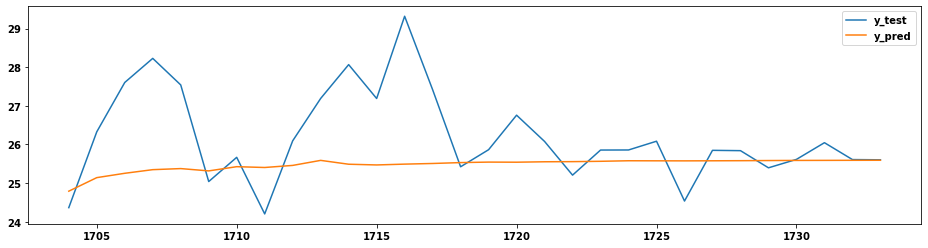

In [17]:
li = [LinearRegression(), KNeighborsRegressor()]
forecaster = ReducedRegressionForecaster(regressor=None, window_length=15, strategy="recursive")

param_grid = {'window_length':[4,5,6,7,8,9,10,12,15,20], 'regressor':li}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"]);

print(gscv.best_params_)

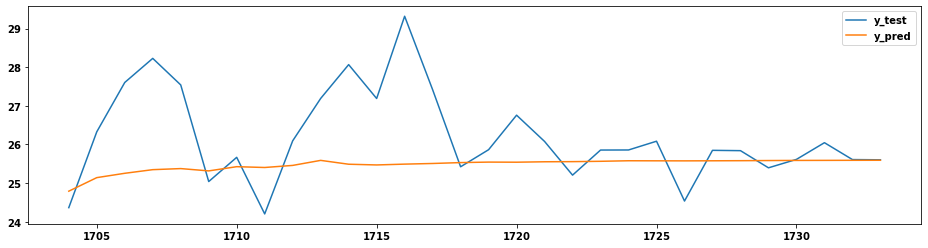

In [18]:
forecaster_min = gscv.best_forecaster_
forecaster_min.fit(y_train)
y_pred = forecaster_min.predict(fh)
plot_ys( y_test, y_pred, labels=["y_test", "y_pred"]);

In [19]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.0366
RMSE 1.37117


,test,pred
1704,24.0,25.0
1705,26.0,25.0
1706,28.0,25.0
1707,28.0,25.0
1708,28.0,25.0
1709,25.0,25.0
1710,26.0,25.0
1711,24.0,25.0
1712,26.0,25.0
1713,27.0,26.0


In [20]:
sts = StandardScaler()
y = np.array(y_dmin).reshape(-1,1)
yn = sts.fit_transform(y)

In [21]:
def sq(seq, step):
    x, y = list(), list()
    for i in range(len(seq)):
        end_x = i + step
        if end_x  > len(seq) -1:
            break
        seq_x, seq_y = seq[i:end_x], seq[end_x]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

Xs, ys = sq(yn, 10)


In [22]:
Xs = Xs.reshape((Xs.shape[0], Xs.shape[1], 1))

In [23]:
X_train, X_test = temporal_train_test_split(np.array(Xs), test_size=0.2)
y_train, y_test = temporal_train_test_split(np.array(ys), test_size=0.2)

print(X_train.shape, y_train.shape)

(1379, 10, 1) (1379, 1)


In [24]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
        activation = 'relu',
      units=64,
        input_shape= X_train.shape
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

In [25]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    shuffle=False,
                   verbose = 0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



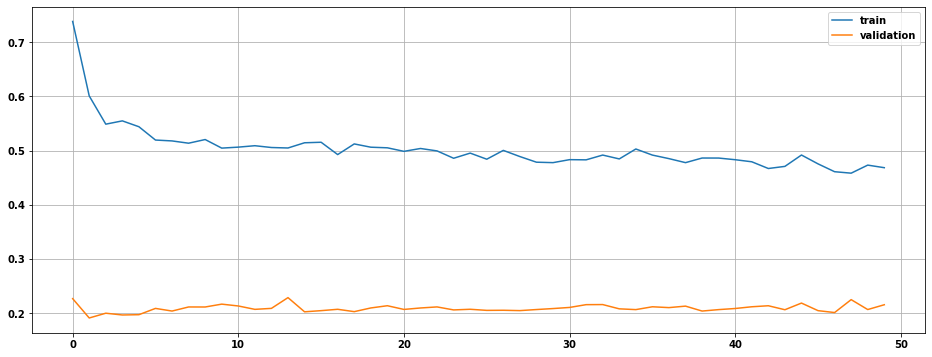

In [26]:
plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='train');
plt.plot(history.history['val_loss'], label='validation');
plt.legend()
plt.grid()

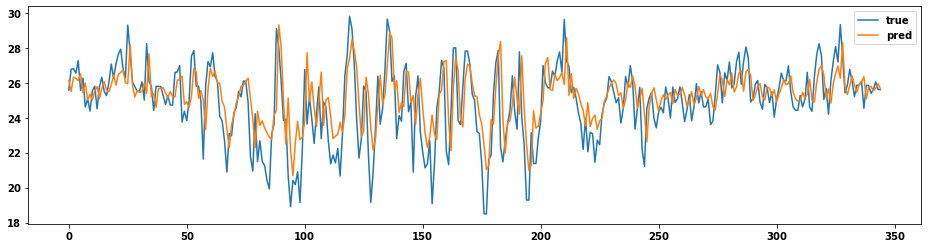

In [27]:
y_pred = model.predict(X_test);

y_pred = sts.inverse_transform(y_pred)
y_test = sts.inverse_transform(y_test)

y_pred = pd.Series(y_pred.flatten(order='F'))
y_test = pd.Series(y_test.flatten(order='F'))

y_pred = pd.Series(y_pred)
y_test = pd.Series(y_test)

plot_ys(pd.Series(y_test), y_pred, labels=['true','pred']);

In [28]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.05077
RMSE 1.64681


,test,pred
0,26.0,26.0
1,27.0,25.0
2,27.0,26.0
3,27.0,26.0
4,27.0,26.0
...,...,...
340,25.0,26.0
341,26.0,26.0
342,26.0,26.0
343,26.0,26.0


#### 2- Check Different Models To Forcast Maximum Temperatures

In [29]:
y_train, y_test = temporal_train_test_split(y_dmax, test_size=30)
print(y_train.shape, y_test.shape)

(1704,) (30,)


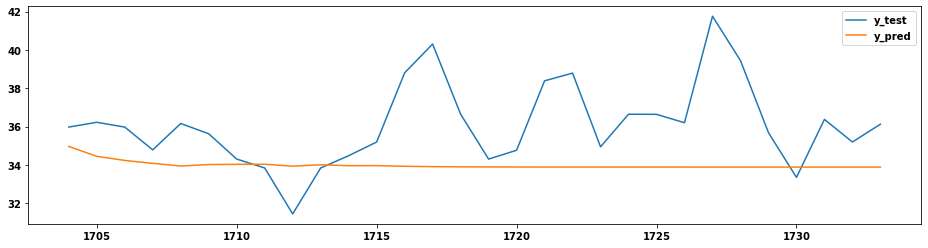

In [30]:
fh = np.arange(len(y_test)) + 1
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(t.fit_transform(y_train))
y_pred = forecaster.predict(fh)
plot_ys(y_test, y_pred, labels=[ "y_test", "y_pred"]);

In [31]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.06461
RMSE 3.00931


,test,pred
1704,36.0,35.0
1705,36.0,34.0
1706,36.0,34.0
1707,35.0,34.0
1708,36.0,34.0
1709,36.0,34.0
1710,34.0,34.0
1711,34.0,34.0
1712,31.0,34.0
1713,34.0,34.0


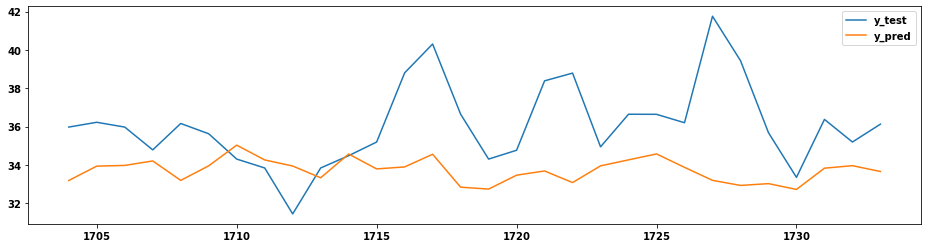

In [32]:
regressor = KNeighborsRegressor(n_neighbors=5)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
forecaster.fit(t.fit_transform(y_train))
y_pred = forecaster.predict(fh)
plot_ys(y_test, y_pred, labels=[ "y_test", "y_pred"]);

In [33]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.07329
RMSE 3.27796


,test,pred
1704,36.0,33.0
1705,36.0,34.0
1706,36.0,34.0
1707,35.0,34.0
1708,36.0,33.0
1709,36.0,34.0
1710,34.0,35.0
1711,34.0,34.0
1712,31.0,34.0
1713,34.0,33.0


{'seasonal': 'multiplicative', 'sp': 90}


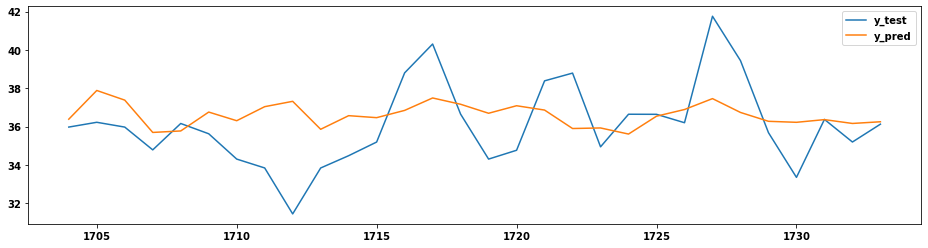

In [34]:
forecaster = ExponentialSmoothing(seasonal='multiplicative', sp=10) 
param_grid = {'seasonal':['add', 'multiplicative' ],'sp':[30,60,90,120,150,180,
                                                                210,240,270,300,330,360]}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"]);

print(gscv.best_params_)

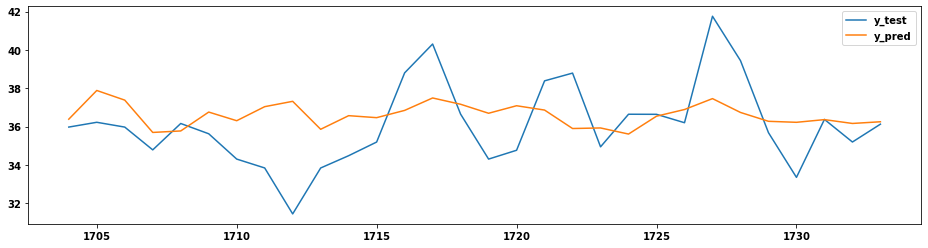

In [35]:
forecaster_max = gscv.best_forecaster_
forecaster_max.fit(y_train)
y_pred = forecaster_max.predict(fh)
plot_ys( y_test, y_pred, labels=["y_test", "y_pred"]);

In [36]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.04694
RMSE 2.14219


,test,pred
1704,36.0,36.0
1705,36.0,38.0
1706,36.0,37.0
1707,35.0,36.0
1708,36.0,36.0
1709,36.0,37.0
1710,34.0,36.0
1711,34.0,37.0
1712,31.0,37.0
1713,34.0,36.0


{'regressor': LinearRegression(), 'window_length': 6}


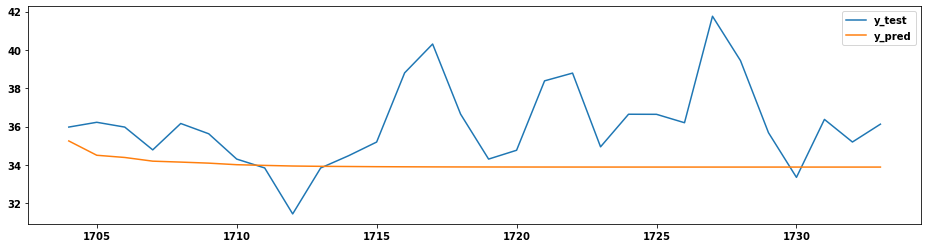

In [37]:
li = [LinearRegression(), KNeighborsRegressor()]
forecaster = ReducedRegressionForecaster(regressor=None, window_length=15, strategy="recursive")

param_grid = {'window_length':[4,5,6,7,8,9,10,12,15,20], 'regressor':li}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"]);

print(gscv.best_params_)

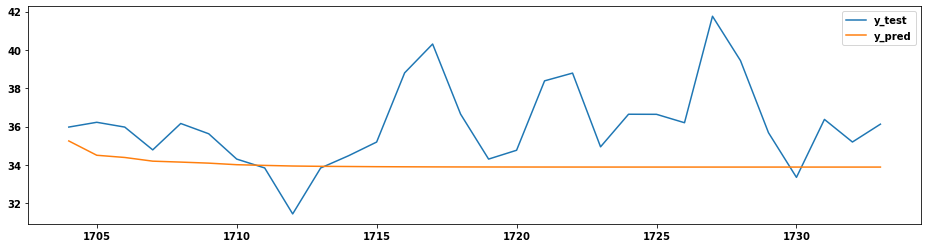

In [38]:
forecaster = gscv.best_forecaster_
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys( y_test, y_pred, labels=["y_test", "y_pred"]);

In [39]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.06377
RMSE 2.99907


,test,pred
1704,36.0,35.0
1705,36.0,35.0
1706,36.0,34.0
1707,35.0,34.0
1708,36.0,34.0
1709,36.0,34.0
1710,34.0,34.0
1711,34.0,34.0
1712,31.0,34.0
1713,34.0,34.0


In [40]:
stm = StandardScaler()
y = np.array(y_dmax).reshape(-1,1)
yn = stm.fit_transform(y)

In [41]:
def sq(seq, step):
    x, y = list(), list()
    for i in range(len(seq)):
        end_x = i + step
        if end_x  > len(seq) -1:
            break
        seq_x, seq_y = seq[i:end_x], seq[end_x]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

Xs, ys = sq(yn, 10)


In [42]:
Xs = Xs.reshape((Xs.shape[0], Xs.shape[1], 1))

In [43]:
X_train, X_test = temporal_train_test_split(np.array(Xs), test_size=0.2)
y_train, y_test = temporal_train_test_split(np.array(ys), test_size=0.2)

print(X_train.shape, y_train.shape)

(1379, 10, 1) (1379, 1)


In [44]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
        activation = 'relu',
      units=64,
        input_shape= X_train.shape
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

In [45]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    shuffle=False,
                   verbose=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



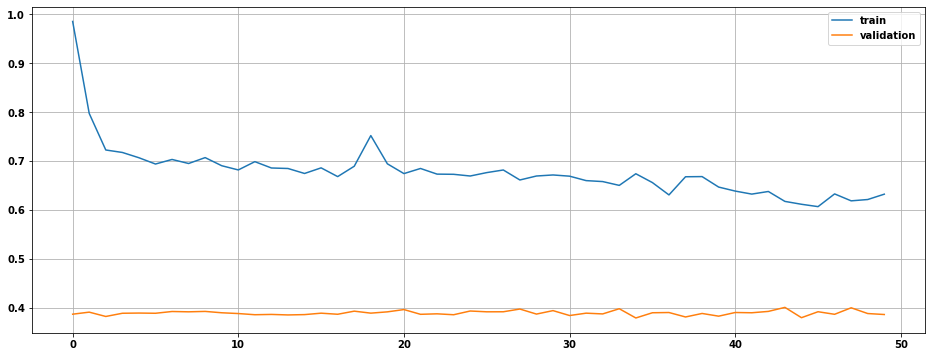

In [46]:
plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='train');
plt.plot(history.history['val_loss'], label='validation');
plt.legend()
plt.grid()

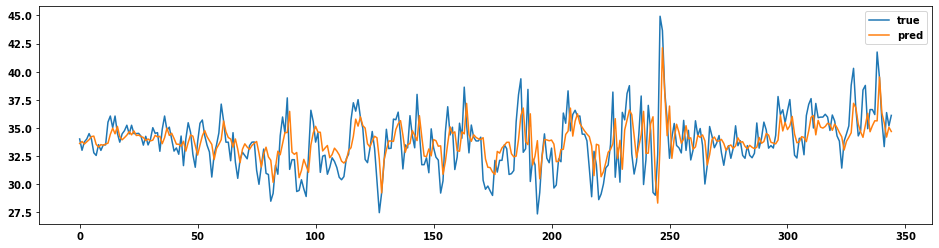

In [47]:
y_pred = model.predict(X_test);

y_pred = stm.inverse_transform(y_pred)
y_test = stm.inverse_transform(y_test)

y_pred = pd.Series(y_pred.flatten(order='F'))
y_test = pd.Series(y_test.flatten(order='F'))

y_pred = pd.Series(y_pred)
y_test = pd.Series(y_test)

plot_ys(pd.Series(y_test), y_pred, labels=['true','pred']);

In [48]:
print('SMAPE',round(smape_loss(y_test, y_pred),5))
print('RMSE', round(np.sqrt(mean_squared_error(y_test, y_pred)),5))
pd.DataFrame({'test':round(y_test) ,'pred':round(y_pred)})

SMAPE 0.04476
RMSE 2.08589


,test,pred
0,34.0,34.0
1,33.0,34.0
2,34.0,34.0
3,34.0,34.0
4,35.0,34.0
...,...,...
340,36.0,36.0
341,33.0,35.0
342,36.0,34.0
343,35.0,35.0
